In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np # Import numpy

drive.mount('/gdrive')

# Define the path to your "flick" folder
folder_path = '/gdrive/MyDrive/code' # Replace 'MyDrive' with your actual Drive folder name if different

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Change the current working directory to the "flick" folder
os.chdir(folder_path)

print(f"Current working directory changed to: {os.getcwd()}")

Mounted at /gdrive
Current working directory changed to: /gdrive/MyDrive/code


In [2]:
# Install dependencies if we are running in colab
import sys
if 'google.colab' in sys.modules:
    %pip install botorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.3/738.3 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Noisy, Parallel, Multi-Objective BO in BoTorch with qEHVI, qNEHVI, and qNParEGO

In this tutorial, we illustrate how to implement a simple multi-objective (MO) Bayesian Optimization (BO) closed loop in BoTorch.

We use the parallel ParEGO ($q$ParEGO), parallel Expected Hypervolume Improvement ($q$EHVI), and parallel Noisy Expected Hypervolume Improvement ($q$NEHVI) acquisition functions to optimize a synthetic ZDT2 problem test function with additive Gaussian observation noise over a 30-parameter search space [0,1]^30. See `botorch/test_functions/multi_objective.py` for details on ZDT2.

Since botorch assumes a maximization of all objectives, we seek to find the Pareto frontier, the set of optimal trade-offs where improving one metric means deteriorating another.

**For batch optimization (or in noisy settings), we strongly recommend using $q$NEHVI rather than $q$EHVI because it is far more efficient than $q$EHVI and mathematically equivalent in the noiseless setting.**

### Set dtype and device
Note: $q$EHVI and $q$NEHVI aggressively exploit parallel hardware and are both much faster when run on a GPU. See [1, 2] for details.

In [3]:
import os
import torch
torch.manual_seed(80)


tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")

### Problem setup


In [4]:
# from botorch.test_functions.multi_objective import DTLZ1


# problem = DTLZ1(dim=6, num_objectives=3, negate=True).to(**tkwargs)

In [5]:
import math
import torch
from torch import Tensor
from typing import Optional
from scipy.special import gamma
from botorch.test_functions.multi_objective import DTLZ
from botorch.utils.sampling import sample_simplex, sample_hypersphere

class DTLZ1a(DTLZ):
    r"""DTLZ1a: Modified DTLZ1 with 3 objectives and 6 variables."""
    _ref_val = 400.0

    def __init__(self, noise_std: Optional[float] = None, negate: bool = False) -> None:
        super().__init__(dim=6, num_objectives=2, noise_std=noise_std, negate=negate)

    def _evaluate_true(self, X: Tensor) -> Tensor:
        X_m = X[..., -self.k :]
        X_m_minus_half = X_m - 0.5
        # Modified cosine frequency: use 10*pi instead of 20*pi
        sum_term = (X_m_minus_half.pow(2) - torch.cos(10 * math.pi * X_m_minus_half)).sum(dim=-1)
        g_X = 100 * (self.k + sum_term)
        g_X_term = 0.5 * (1 + g_X)
        fs = []
        for i in range(self.num_objectives):
            idx = self.num_objectives - 1 - i
            f_i = g_X_term * X[..., :idx].prod(dim=-1)
            if i > 0:
                f_i = f_i * (1 - X[..., idx])
            fs.append(f_i)
        return torch.stack(fs, dim=-1)

    def gen_pareto_front(self, n: int) -> Tensor:
        f_X = 0.5 * sample_simplex(
            n=n,
            d=self.num_objectives,
            qmc=True,
            dtype=self.ref_point.dtype,
            device=self.ref_point.device,
        )
        if self.negate:
            f_X *= -1
        return f_X

    @property
    def _max_hv(self) -> float:
        return self._ref_val ** self.num_objectives - 1.0 / (2 ** self.num_objectives)




In [6]:
problem = DTLZ1a(negate=True).to(**tkwargs)
print(problem.ref_point, end="\n")
print(problem.max_hv, end="\n")
print(problem.bounds, end="\n")

tensor([-400., -400.], device='cuda:0', dtype=torch.float64)
159999.75
tensor([[0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.]], device='cuda:0', dtype=torch.float64)


#### Model initialization

We use a list of `SingleTaskGP`s to model the two objectives with known noise variances. If no noise variances were provided, `SingleTaskGP` would infer (homoskedastic) noise levels instead.

The models are initialized with $2(d+1)=6$ points drawn randomly from $[0,1]^2$.

In [7]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils.sampling import draw_sobol_samples

n_initial = 11 * problem.dim - 1

def generate_initial_data(n=n_initial):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj_true = problem(train_x)
    train_obj = train_obj_true
    return train_x, train_obj, train_obj_true



from botorch.models.gp_regression import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

def initialize_model(train_x, train_obj):
    train_x = normalize(train_x, problem.bounds)
    train_y = train_obj  # Shape: [n, 2]

    model = SingleTaskGP(
        train_x,
        train_y,
        outcome_transform=Standardize(m=2),  # Standardize both objectives
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

#### Define a helper functions that performs the essential BO step for $q$EHVI and $q$NEHVI
The helper function below initializes the $q$EHVI acquisition function, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values.

For this example, we'll use a relatively small batch of optimization ($q=4$). For batch optimization ($q>1$), passing the keyword argument `sequential=True` to the function `optimize_acqf`specifies that candidates should be optimized in a sequential greedy fashion (see [1] for details why this is important). A simple initialization heuristic is used to select the 10 restart initial locations from a set of 512 random points. Multi-start optimization of the acquisition function is performed using LBFGS-B with exact gradients computed via auto-differentiation.

**Reference Point**

$q$EHVI requires specifying a reference point, which is the lower bound on the objectives used for computing hypervolume. In this tutorial, we assume the reference point is known. In practice the reference point can be set 1) using domain knowledge to be slightly worse than the lower bound of objective values, where the lower bound is the minimum acceptable value of interest for each objective, or 2) using a dynamic reference point selection strategy.

**Partitioning the Non-dominated Space into disjoint rectangles**

$q$EHVI requires partitioning the non-dominated space into disjoint rectangles (see [1] for details).

*Note:* `FastNondominatedPartitioning` *will be very slow when 1) there are a lot of points on the pareto frontier and 2) there are >5 objectives.*

In [8]:
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    NondominatedPartitioning,
)
from botorch.acquisition.multi_objective import (
    qLogExpectedHypervolumeImprovement,
    qLogNoisyExpectedHypervolumeImprovement,
)
from botorch.utils.sampling import sample_simplex


BATCH_SIZE = 5
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4

standard_bounds = torch.zeros(2, problem.dim, **tkwargs)
standard_bounds[1] = 1


def optimize_qehvi_and_get_observation(model, train_x, train_obj, sampler):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    with torch.no_grad():
        pred = model.posterior(normalize(train_x, problem.bounds)).mean
    partitioning = NondominatedPartitioning(
        ref_point=problem.ref_point,
        Y=pred,
    )
    acq_func = qLogExpectedHypervolumeImprovement(
        model=model,
        ref_point=problem.ref_point,
        partitioning=partitioning,
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj_true = problem(new_x)
    print("ehvi",new_obj_true)
    new_obj = new_obj_true
    return new_x, new_obj, new_obj_true

#### Define a helper function that performs the essential BO step for $q$NParEGO
The helper function below similarly initializes $q$NParEGO, optimizes it, and returns the batch $\{x_1, x_2, \ldots x_q\}$ along with the observed function values.

$q$NParEGO uses random augmented chebyshev scalarization with the `qNoisyExpectedImprovement` acquisition function. In the parallel setting ($q>1$), each candidate is optimized in sequential greedy fashion using a different random scalarization (see [1] for details).

To do this, we create a list of `qNoisyExpectedImprovement` acquisition functions, each with different random scalarization weights. The `optimize_acqf_list` method sequentially generates one candidate per acquisition function and conditions the next candidate (and acquisition function) on the previously selected pending candidates.

In [9]:
from botorch.acquisition import qLogNoisyExpectedImprovement


def optimize_qnparego_and_get_observation(model, train_x, train_obj, sampler):
    """Samples a set of random weights for each candidate in the batch, performs sequential greedy optimization
    of the qNParEGO acquisition function, and returns a new candidate and observation."""
    train_x = normalize(train_x, problem.bounds)
    with torch.no_grad():
        pred = model.posterior(train_x).mean
    acq_func_list = []
    for _ in range(BATCH_SIZE):
        weights = sample_simplex(problem.num_objectives, **tkwargs).squeeze()
        objective = GenericMCObjective(
            get_chebyshev_scalarization(weights=weights, Y=pred)
        )
        acq_func = qLogNoisyExpectedImprovement(  # pyre-ignore: [28]
            model=model,
            objective=objective,
            X_baseline=train_x,
            sampler=sampler,
            prune_baseline=True,
        )
        acq_func_list.append(acq_func)
    # optimize
    candidates, _ = optimize_acqf_list(
        acq_function_list=acq_func_list,
        bounds=standard_bounds,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )
    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj_true = problem(new_x)
    print(new_obj_true)
    new_obj = new_obj_true #+ torch.randn_like(new_obj_true) * NOISE_SE
    return new_x, new_obj, new_obj_true

### Perform Bayesian Optimization loop with $q$NEHVI, $q$EHVI, and $q$NParEGO
The Bayesian optimization "loop" for a batch size of $q$ simply iterates the following steps:
1. given a surrogate model, choose a batch of points $\{x_1, x_2, \ldots x_q\}$
2. observe $f(x)$ for each $x$ in the batch
3. update the surrogate model.


Just for illustration purposes, we run one trial with `N_BATCH=20` rounds of optimization. The acquisition function is approximated using `MC_SAMPLES=128` samples.

*Note*: Running this may take a little while.

In [10]:
import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    NondominatedPartitioning,
)
from botorch.utils.multi_objective.pareto import is_non_dominated


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

N_BATCH = 2 if not SMOKE_TEST else 4
MC_SAMPLES = 128 if not SMOKE_TEST else 16

verbose = True

hvs_qparego, hvs_qehvi = [], []

# call helper functions to generate initial training data and initialize model
train_x_qparego, train_obj_qparego, train_obj_true_qparego = generate_initial_data()
mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_qparego)

train_x_qehvi, train_obj_qehvi, train_obj_true_qehvi = (
    train_x_qparego,
    train_obj_qparego,
    train_obj_true_qparego,
)
mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi)

# compute hypervolume
bd = NondominatedPartitioning(ref_point=problem.ref_point, Y=train_obj_true_qparego)
volume = bd.compute_hypervolume().item()

hvs_qparego.append(volume)
hvs_qehvi.append(volume)

# run N_BATCH rounds of BayesOpt after the initial random batch
for iteration in range(1, N_BATCH + 1):

    t0 = time.monotonic()

    # fit the models
    fit_gpytorch_mll(mll_qparego)
    fit_gpytorch_mll(mll_qehvi)

    # define the qEI and qNEI acquisition modules using a QMC sampler
    qparego_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))
    qehvi_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

    # optimize acquisition functions and get new observations
    (
        new_x_qparego,
        new_obj_qparego,
        new_obj_true_qparego,
    ) = optimize_qnparego_and_get_observation(
        model_qparego, train_x_qparego, train_obj_qparego, qparego_sampler
    )
    new_x_qehvi, new_obj_qehvi, new_obj_true_qehvi = optimize_qehvi_and_get_observation(
        model_qehvi, train_x_qehvi, train_obj_qehvi, qehvi_sampler
    )

    # update training points
    train_x_qparego = torch.cat([train_x_qparego, new_x_qparego])
    train_obj_qparego = torch.cat([train_obj_qparego, new_obj_qparego])
    train_obj_true_qparego = torch.cat([train_obj_true_qparego, new_obj_true_qparego])

    train_x_qehvi = torch.cat([train_x_qehvi, new_x_qehvi])
    train_obj_qehvi = torch.cat([train_obj_qehvi, new_obj_qehvi])
    train_obj_true_qehvi = torch.cat([train_obj_true_qehvi, new_obj_true_qehvi])


    # update progress
    for hvs_list, train_obj in zip(
        (hvs_qparego, hvs_qehvi),
        (
            train_obj_true_qparego,
            train_obj_true_qehvi,
        ),
    ):
        # compute hypervolume
        bd = NondominatedPartitioning(ref_point=problem.ref_point, Y=train_obj)
        volume = bd.compute_hypervolume().item()
        hvs_list.append(volume)

    # reinitialize the models so they are ready for fitting on next iteration
    # Note: we find improved performance from not warm starting the model hyperparameters
    # using the hyperparameters from the previous iteration
    mll_qparego, model_qparego = initialize_model(train_x_qparego, train_obj_qparego)
    mll_qehvi, model_qehvi = initialize_model(train_x_qehvi, train_obj_qehvi)

    t1 = time.monotonic()

    if verbose:
        print(
            f"\nBatch {iteration:>2}: Hypervolume (qNParEGO, qEHVI) = "
            f"({hvs_qparego[-1]:>4.2f}, {hvs_qehvi[-1]:>4.2f}), "
            f"time = {t1-t0:>4.2f}.",
            end="",
        )
    else:
        print(".", end="")

tensor([[-116.3458, -258.8422],
        [-116.4116, -203.8257],
        [ -58.3910, -338.1786],
        [-287.4813,   -7.2299],
        [ -73.2114, -221.5300]], device='cuda:0', dtype=torch.float64)
ehvi tensor([[  -0.0000, -563.0000],
        [-166.7223, -382.5298],
        [-304.9638,   -6.2623],
        [ -95.3568, -458.4847],
        [  -0.0000, -563.0000]], device='cuda:0', dtype=torch.float64)

Batch  1: Hypervolume (qNParEGO, qEHVI) = (142218.67, 142237.98), time = 97.24.tensor([[-303.5685, -259.2918],
        [-419.1044,   -0.0000],
        [-238.0523, -306.8768],
        [ -40.0009, -522.8985],
        [-319.9355, -243.0645]], device='cuda:0', dtype=torch.float64)
ehvi tensor([[-214.5437, -348.4563],
        [-102.3478, -274.9136],
        [-433.2240,  -34.3165],
        [  -0.0000, -435.2752],
        [ -86.2934, -257.0104]], device='cuda:0', dtype=torch.float64)

Batch  2: Hypervolume (qNParEGO, qEHVI) = (142218.67, 142237.98), time = 76.21.

### Plot the results
The plot below shows the a common metric of multi-objective optimization performance, the log hypervolume difference: the log difference between the hypervolume of the true pareto front and the hypervolume of the approximate pareto front identified by each algorithm. The log hypervolume difference is plotted at each step of the optimization for each of the algorithms.

The plot shows that $q$NEHVI outperforms $q$EHVI and $q$ParEGO.

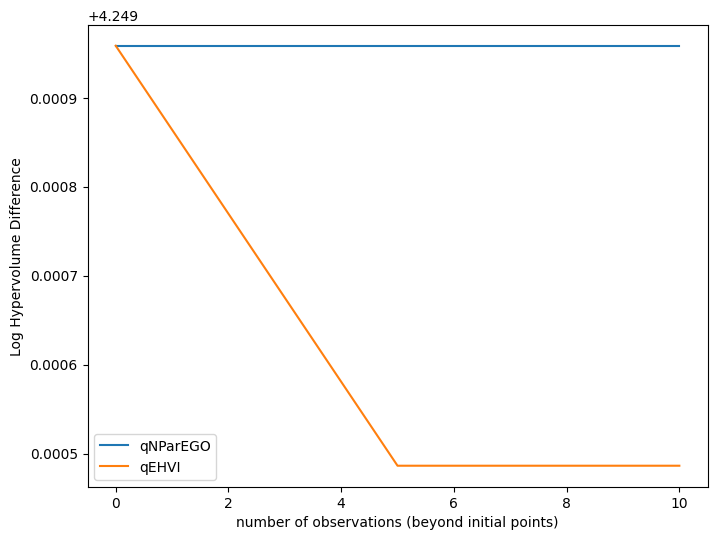

In [11]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline


iters = np.arange(N_BATCH + 1) * BATCH_SIZE
log_hv_difference_qparego = np.log10(problem.max_hv - np.asarray(hvs_qparego))
log_hv_difference_qehvi = np.log10(problem.max_hv - np.asarray(hvs_qehvi))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(
    iters,
    log_hv_difference_qparego,
    label="qNParEGO",
    linewidth=1.5,
)
ax.errorbar(
    iters,
    log_hv_difference_qehvi,
    label="qEHVI",
    linewidth=1.5,
)
ax.set(
    xlabel="number of observations (beyond initial points)",
    ylabel="Log Hypervolume Difference",
)
ax.legend(loc="lower left")

#### Plot the true objectives at the evaluated designs colored by iteration

To examine optimization process from another perspective, we plot the true function values at the designs selected under each algorithm where the color corresponds to the BO iteration at which the point was collected. The plot on the right for $q$NEHVI shows that the $q$NEHVI quickly identifies the pareto front and most of its evaluations are very close to the pareto front. $q$NParEGO also identifies has many observations close to the pareto front, but relies on optimizing random scalarizations, which is a less principled way of optimizing the pareto front compared to $q$NEHVI, which explicitly attempts focuses on improving the pareto front. $q$EHVI uses the posterior mean as a plug-in estimator for the true function values at the in-sample points, whereas $q$NEHVI than integrating over the uncertainty at the in-sample designs Sobol generates random points and has few points close to the Pareto front.

Text(0.5, 1.0, 'Iteration')

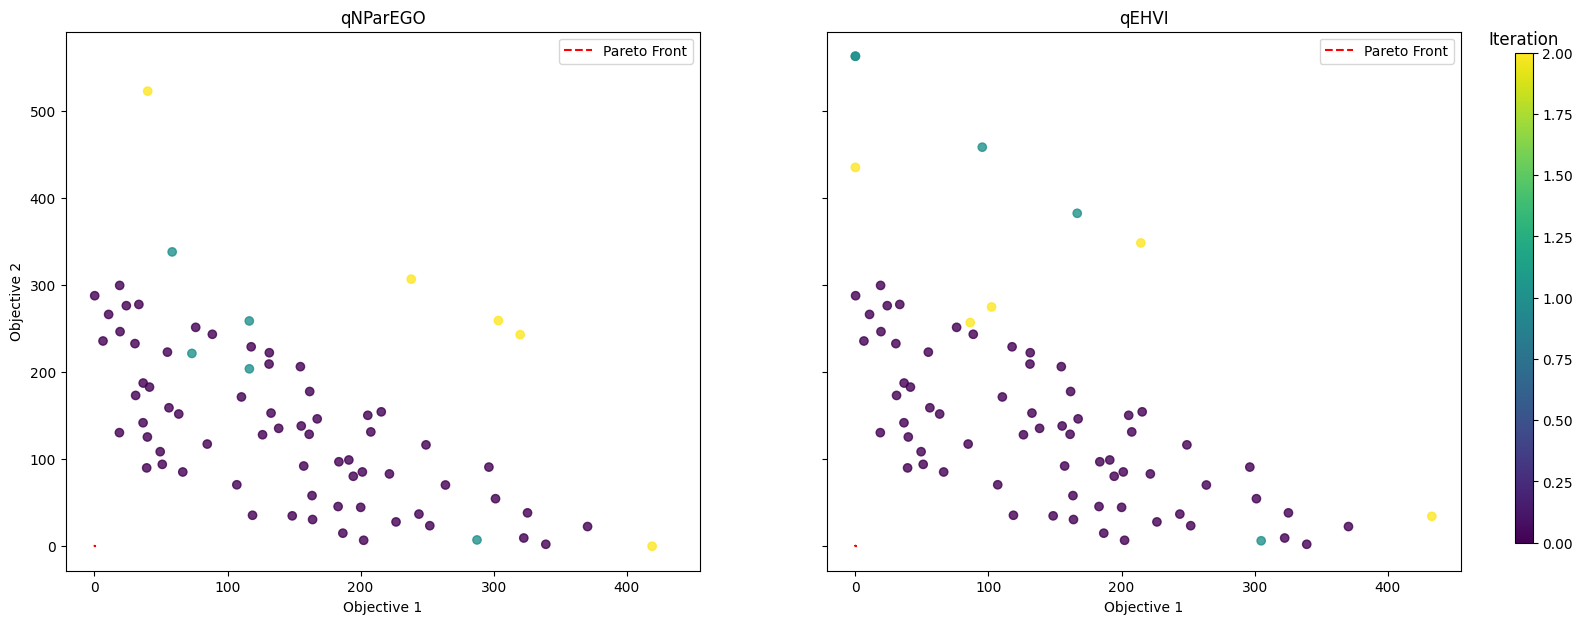

In [14]:
from matplotlib.cm import ScalarMappable


pareto_front = -problem.gen_pareto_front(n=1000).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharex=True, sharey=True)
algos = ["qNParEGO", "qEHVI"]
cm = plt.get_cmap("viridis")

batch_number = torch.cat(
    [
        torch.zeros(11 * problem.dim - 1),
        torch.arange(1, N_BATCH + 1).repeat(BATCH_SIZE, 1).t().reshape(-1),
    ]
).numpy()
for i, train_obj in enumerate(
    (
        train_obj_true_qparego,
        train_obj_true_qehvi,
    )
):
    sc = axes[i].scatter(
        -train_obj[:, 0].cpu().numpy(),
        -train_obj[:, 1].cpu().numpy(),
        c=batch_number,
        alpha=0.8,
    )
    axes[i].plot(pareto_front[:, 0], pareto_front[:, 1], "r--", label="Pareto Front")
    axes[i].set_title(algos[i])
    axes[i].set_xlabel("Objective 1")
    axes[i].legend()
axes[0].set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm = ScalarMappable(norm=norm, cmap=plt.get_cmap("viridis"))
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")

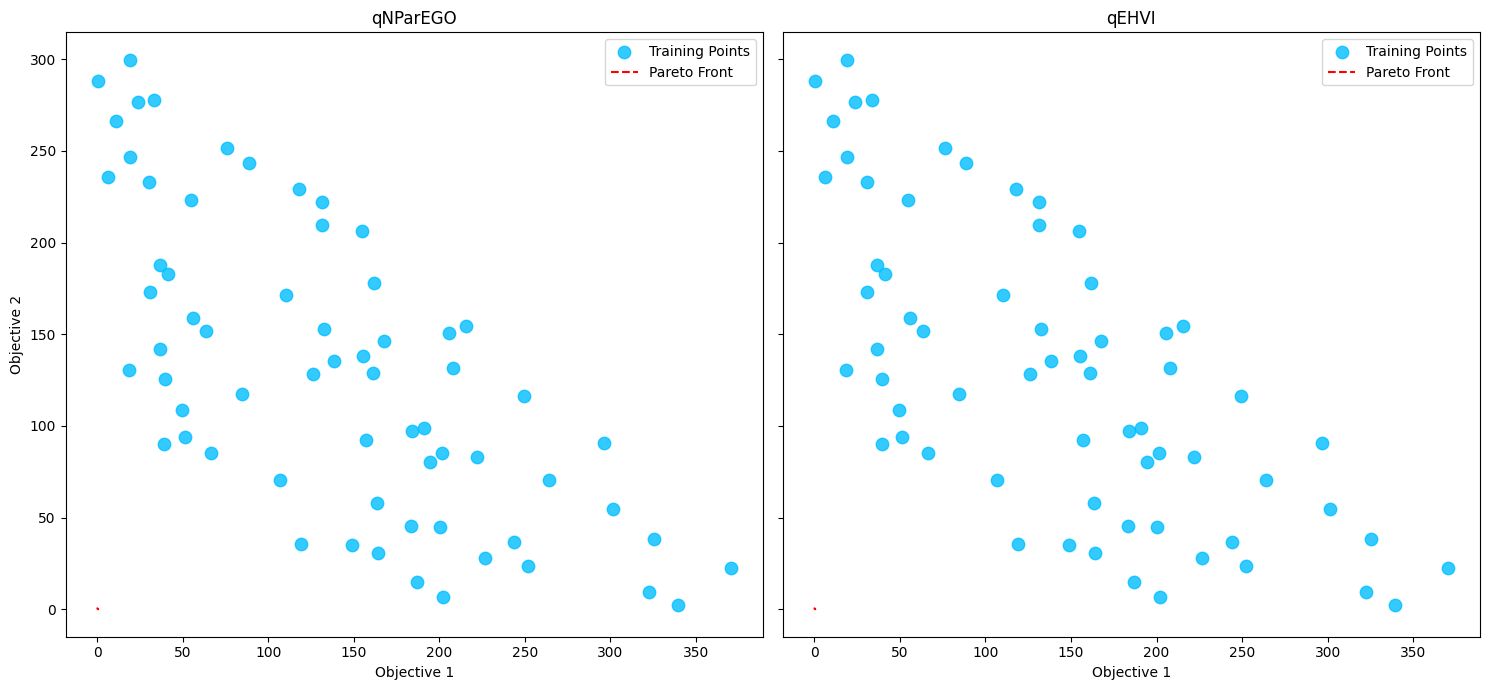

In [15]:
import matplotlib.pyplot as plt

# Assume train_obj_true_qparego and train_obj_true_qehvi are torch tensors
# and problem.dim is defined, as well as pareto_front

fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
algos = ["qNParEGO", "qEHVI"]

for i, train_obj in enumerate((train_obj_true_qparego, train_obj_true_qehvi)):
    axes[i].scatter(
        -train_obj[:n_initial, 0].cpu().numpy(),
        -train_obj[:n_initial, 1].cpu().numpy(),
        c="deepskyblue", s=80, alpha=0.8, label="Training Points"
    )
    axes[i].plot(
        pareto_front[:, 0], pareto_front[:, 1], "r--", label="Pareto Front"
    )
    axes[i].set_title(algos[i])
    axes[i].set_xlabel("Objective 1")
    axes[i].legend()
axes[0].set_ylabel("Objective 2")
plt.tight_layout()
plt.show()


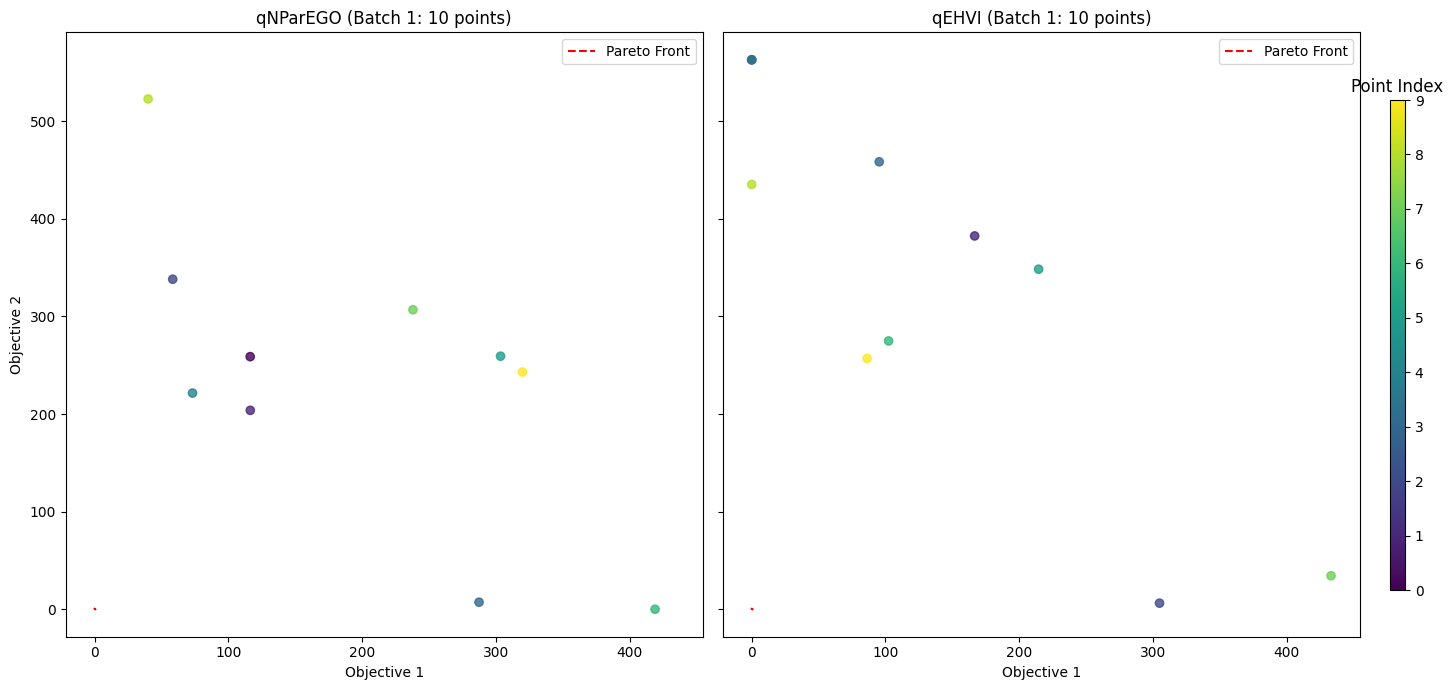

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Generate the Pareto front (assuming this is already defined)
pareto_front = -problem.gen_pareto_front(n=1000).cpu().numpy()

# Number of points per batch
batch_size = 50

# Plot batches of points after skipping initial training points
def plot_batches_after_training(train_obj_true_qparego, train_obj_true_qehvi, pareto_front, n_initial, batch_size):
    algos = ["qNParEGO", "qEHVI"]
    train_objs = [train_obj_true_qparego, train_obj_true_qehvi]

    # Calculate total points in each train_obj
    total_points = train_obj_true_qparego.shape[0]

    # Calculate number of points after initial training
    n_remaining = total_points - n_initial

    # Calculate number of plots needed
    n_plots = (n_remaining + batch_size - 1) // batch_size

    for plot_idx in range(n_plots):
        fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
        cm = plt.get_cmap("viridis")

        start_idx = n_initial + plot_idx * batch_size
        end_idx = min(start_idx + batch_size, total_points)

        for i, train_obj in enumerate(train_objs):
            # Get the current batch of points
            batch_points = train_obj[start_idx:end_idx]

            # Generate indices for coloring (relative to this batch)
            indices = np.arange(end_idx - start_idx)

            # Plot the points
            sc = axes[i].scatter(
                -batch_points[:, 0].cpu().numpy(),
                -batch_points[:, 1].cpu().numpy(),
                c=indices,
                cmap=cm,
                alpha=0.8
            )

            # Plot Pareto front
            axes[i].plot(pareto_front[:, 0], pareto_front[:, 1], "r--", label="Pareto Front")

            # Set titles and labels
            axes[i].set_title(f"{algos[i]} (Batch {plot_idx+1}: {len(indices)} points)")
            axes[i].set_xlabel("Objective 1")
            axes[i].legend()

        axes[0].set_ylabel("Objective 2")

        # Add colorbar
        norm = plt.Normalize(indices.min(), indices.max())
        sm = ScalarMappable(norm=norm, cmap=cm)
        sm.set_array([])
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
        cbar = fig.colorbar(sm, cax=cbar_ax)
        cbar.ax.set_title("Point Index")

        plt.tight_layout(rect=[0, 0, 0.92, 1])
        plt.show()

# Call the function to generate the plots
plot_batches_after_training(train_obj_true_qparego, train_obj_true_qehvi, pareto_front, n_initial, batch_size)


In [23]:
import pandas as pd

# Convert PyTorch tensors to numpy arrays
train_x_qparego_np = train_x_qparego.cpu().numpy()
train_obj_qparego_np = train_obj_qparego.cpu().numpy()
train_x_qehvi_np = train_x_qehvi.cpu().numpy()
train_obj_qehvi_np = train_obj_qehvi.cpu().numpy()

# Concatenate the input dimensions and objectives horizontally
qparego_data = np.hstack([train_x_qparego_np, train_obj_qparego_np])
qehvi_data = np.hstack([train_x_qehvi_np, train_obj_qehvi_np])

# Create column headers for better readability
input_dim = train_x_qparego.shape[1]
obj_dim = train_obj_qparego.shape[1]
column_names = [f"dim{i+1}" for i in range(input_dim)] + [f"obj{i+1}" for i in range(obj_dim)]

# Create DataFrames with the combined data and column names
qparego_df = pd.DataFrame(qparego_data, columns=column_names)
qehvi_df = pd.DataFrame(qehvi_data, columns=column_names)

# Save to CSV files
qparego_df.to_csv('DTLZ1a (6-3) qNParEGO_data.csv', index=False, mode='w')
qehvi_df.to_csv('DTLZ1a (6-3) qEHVI_data.csv', index=False, mode='w')

print("ParEGO data saved to 'DTLZ1a (6-3) qNParEGO_data.csv'")
print("EHVI data saved to 'DTLZ1a (6-3) qEHVI_data.csv'")


ParEGO data saved to 'DTLZ1a (6-3) qNParEGO_data.csv'
EHVI data saved to 'DTLZ1a (6-3) qEHVI_data.csv'


In [24]:
def plot_pareto_front_2d(train_obj_true_qparego, train_obj_true_qehvi, pareto_front=None):
    if pareto_front is None:
        pareto_front = -problem.gen_pareto_front(n=1000).cpu().numpy()

    fig = make_subplots(rows=1, cols=2,
                       subplot_titles=("qNParEGO", "qEHVI"),
                       horizontal_spacing=0.1)

    batch_number = torch.cat(
        [
            torch.zeros(n_initial),
            torch.arange(1, N_BATCH + 1).repeat(BATCH_SIZE, 1).t().reshape(-1),
        ]
    ).numpy()

    for i, (train_obj, title) in enumerate([(train_obj_true_qparego, "qNParEGO"),
                                           (train_obj_true_qehvi, "qEHVI")], 1):
        # Convert to numpy
        obj_np = -train_obj.cpu().numpy()

        # Add scatter plot for objective values
        fig.add_trace(
            go.Scatter(
                x=obj_np[:, 0],
                y=obj_np[:, 1],
                mode='markers',
                marker=dict(
                    size=8,
                    color=batch_number[:len(obj_np)],
                    colorscale='Viridis',
                    colorbar=dict(title='Iteration') if i == 2 else None,
                    opacity=0.7
                ),
                name=title
            ),
            row=1, col=i
        )

        # Add Pareto front
        fig.add_trace(
            go.Scatter(
                x=pareto_front[:, 0],
                y=pareto_front[:, 1],
                mode='lines',
                line=dict(color='red', width=2),
                name='True Pareto Front'
            ),
            row=1, col=i
        )

    # Update layout
    fig.update_layout(
        height=500,
        width=1200,
        showlegend=False,
        title_text="Objective Space - DTLZ1a with 2 Objectives",
    )

    # Set consistent axis ranges
    fig.update_xaxes(title_text="Objective 1", range=[0, 0.5], row=1, col=1)
    fig.update_yaxes(title_text="Objective 2", range=[0, 0.5], row=1, col=1)
    fig.update_xaxes(title_text="Objective 1", range=[0, 0.5], row=1, col=2)
    fig.update_yaxes(title_text="Objective 2", range=[0, 0.5], row=1, col=2)

    return fig

plot_pareto_front_2d(train_obj_true_qparego, train_obj_true_qehvi)

####plots if is obj =3

In [25]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import numpy as np

# def create_pareto_surface(problem, n=1000):
#     # Generate Pareto front using the problem's built-in method
#     pareto_front = -problem.gen_pareto_front(n).cpu().numpy()

#     if problem.num_objectives == 3:
#         # Create Mesh3d trace for 3D problems
#         return go.Mesh3d(
#             x=pareto_front[:, 0],
#             y=pareto_front[:, 1],
#             z=pareto_front[:, 2],
#             color='red',
#             opacity=0.3,
#             intensity=pareto_front[:, 2],
#             colorscale='Reds',
#             showscale=False,
#             name='Pareto Front'
#         )
#     else:
#         raise ValueError("Only 3D visualization is supported in this implementation")


In [26]:
# # 1. Plot showing just initial training points
# fig_initial = make_subplots(
#     rows=1, cols=2,
#     specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
#     subplot_titles=("qNParEGO", "qEHVI")
# )

# # Generate Pareto surface using problem's built-in method
# pf_surface = create_pareto_surface(problem)

# alg_data_initial = [
#     (-train_obj_true_qparego[:n_initial], "qNParEGO"),
#     (-train_obj_true_qehvi[:n_initial], "qEHVI"),
# ]

# for col, (train_obj, name) in enumerate(alg_data_initial, 1):
#     obj_np = train_obj.cpu().numpy() if isinstance(train_obj, torch.Tensor) else train_obj

#     # Plot initial points
#     scatter = go.Scatter3d(
#         x=obj_np[:, 0], y=obj_np[:, 1], z=obj_np[:, 2],
#         mode='markers',
#         marker=dict(size=4, color='deepskyblue', opacity=0.8),
#         name=name
#     )

#     fig_initial.add_trace(scatter, row=1, col=col)
#     fig_initial.add_trace(pf_surface, row=1, col=col)

# # Update layout
# fig_initial.update_layout(
#     height=600,
#     width=1200,
#     scene1=dict(
#         xaxis_title='Objective 1',
#         yaxis_title='Objective 2',
#         zaxis_title='Objective 3',
#         camera=dict(eye=dict(x=1.5, y=1.5, z=0.6))
#     ),
#     scene2=dict(
#         xaxis_title='Objective 1',
#         yaxis_title='Objective 2',
#         zaxis_title='Objective 3',
#         camera=dict(eye=dict(x=1.5, y=1.5, z=0.6))
#     ),
#     showlegend=False,
#     title_text='Initial Training Points'
# )
# fig_initial.show()

In [27]:

# # 2. Plot batches of points after initial points
# batch_size = 50
# batch_number = torch.cat(
#     [
#         torch.zeros(11 * problem.dim - 1),
#         torch.arange(1, N_BATCH + 1).repeat(BATCH_SIZE, 1).t().reshape(-1),
#     ]
# ).numpy()
# n_points = min(len(train_obj_true_qparego), len(train_obj_true_qehvi))
# n_remaining = n_points - n_initial
# n_plots = (n_remaining + batch_size - 1) // batch_size

# for plot_idx in range(n_plots):
#     fig = make_subplots(
#         rows=1, cols=2,
#         specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
#         subplot_titles=("qNParEGO", "qEHVI")
#     )

#     start_idx = n_initial + plot_idx * batch_size
#     end_idx = min(start_idx + batch_size, n_points)

#     alg_data = [
#         (-train_obj_true_qparego[start_idx:end_idx], "qNParEGO"),
#         (-train_obj_true_qehvi[start_idx:end_idx], "qEHVI"),
#     ]

#     for col, (train_obj, name) in enumerate(alg_data, 1):
#         obj_np = train_obj.cpu().numpy() if isinstance(train_obj, torch.Tensor) else train_obj

#         # Plot batch points
#         scatter = go.Scatter3d(
#             x=obj_np[:, 0], y=obj_np[:, 1], z=obj_np[:, 2],
#             mode='markers',
#             marker=dict(
#                 size=4,
#                 color=batch_number[start_idx:end_idx],
#                 colorscale='Viridis',
#                 opacity=0.8,
#                 colorbar=dict(title='Iteration') if col == 2 else None
#             ),
#             name=name
#         )

#         fig.add_trace(scatter, row=1, col=col)
#         fig.add_trace(pf_surface, row=1, col=col)

#     # Update layout
#     fig.update_layout(
#         height=600,
#         width=1200,
#         scene1=dict(
#             xaxis_title='Objective 1',
#             yaxis_title='Objective 2',
#             zaxis_title='Objective 3',
#             camera=dict(eye=dict(x=1.5, y=1.5, z=0.6))
#         ),
#         scene2=dict(
#             xaxis_title='Objective 1',
#             yaxis_title='Objective 2',
#             zaxis_title='Objective 3',
#             camera=dict(eye=dict(x=1.5, y=1.5, z=0.6))
#         ),
#         showlegend=False,
#         title_text=f'Cumulative: First {end_idx - start_idx} Points After training'
#     )
#     fig.show()
